In [105]:
import os
import sys
import pandas as pd
import re


In [106]:
test_df = pd.read_csv('../../data/spanish/test.csv')
train_df = pd.read_csv('../../data/spanish/train.csv')
val_df = pd.read_csv('../../data/spanish/valid.csv')


test_df.head()

,text,label,source
0,"@user jajajaja dale, hacete la boluda vos jaja...",negative,intertass_2017
1,cada vez que cito un tweet se va la ubicación ...,neutral,intertass_2017
2,@user MAAAAE RAJADO! Pero lo bueno es q uno se...,positive,intertass_2017
3,Bueno hoy fui a almorzar a Nanay con otras 3 d...,negative,intertass_2017
4,Necesito seguir a mas cuentas camren shippers ...,neutral,intertass_2017


In [107]:
from sklearn.model_selection import train_test_split

train_df, _ = train_test_split(
    train_df,
    test_size = 0.5 ,
    stratify = train_df['label'],
    random_state = 42
)

In [108]:
train_df['label'].unique()


mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

# Create a new column with mapped values
train_df['sentiment_num'] = train_df['label'].map(mapping)
test_df['sentiment_num'] = test_df['label'].map(mapping)
val_df['sentiment_num'] = val_df['label'].map(mapping)

In [109]:
test_df.head()

,text,label,source,sentiment_num
0,"@user jajajaja dale, hacete la boluda vos jaja...",negative,intertass_2017,0
1,cada vez que cito un tweet se va la ubicación ...,neutral,intertass_2017,1
2,@user MAAAAE RAJADO! Pero lo bueno es q uno se...,positive,intertass_2017,2
3,Bueno hoy fui a almorzar a Nanay con otras 3 d...,negative,intertass_2017,0
4,Necesito seguir a mas cuentas camren shippers ...,neutral,intertass_2017,1


In [110]:
url_pattern = re.compile(r"http\S+|www\.\S+")
mention_pattern = re.compile(r"@\w+")
hashtag_pattern = re.compile(r"#(\w+)")
rt_pattern = re.compile(r"^RT\s+@\w+:\s*")

def normalize_elongation(word, max_repeat=2):
    # "buenooo" -> "buenoo" (limit repeated chars)
    return re.sub(r"(.)\1{"+str(max_repeat)+r",}", r"\1"*max_repeat, word)

def clean_tweet(text: str) -> str:
    if not isinstance(text, str):
        return ""
    
    # 1) Remove RT at the beginning
    text = rt_pattern.sub("", text)

    # 2) Remove URLs
    text = url_pattern.sub(" URL ", text)

    # 3) Normalize mentions
    text = mention_pattern.sub(" @usuario ", text)

    # 4) Turn hashtags into just the word part: #FelizLunes -> FelizLunes
    text = hashtag_pattern.sub(r"\1", text)

    # 5) Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # 6) Optionally lowercase (good for uncased models)
    text = text.lower()

    # 7) Optional: normalize character elongation word-by-word
    tokens = []
    for tok in text.split():
        tokens.append(normalize_elongation(tok))
    text = " ".join(tokens)

    return text

In [111]:
train_df["clean_text"] = train_df["text"].apply(clean_tweet)
test_df["clean_text"] = test_df["text"].apply(clean_tweet)
val_df["clean_text"] = val_df["text"].apply(clean_tweet)

In [112]:
train_df.head()

,text,label,source,sentiment_num,clean_text
993,@user Que cabrito y te quito años @user per...,negative,intertass_2017,0,@usuario que cabrito y te quito años @usuario ...
519,"@user hoy me he gastado 90 euros en LEGOs, así...",negative,intertass_2017,0,"@usuario hoy me he gastado 90 euros en legos, ..."
175,@user Yo estoy valorando Movistar. Son careros...,neutral,intertass_2017,1,@usuario yo estoy valorando movistar. son care...
730,y quiero ir de nuevo al Cosmocaixa,neutral,intertass_2017,1,y quiero ir de nuevo al cosmocaixa
1148,@user ya sabia yo que si,positive,intertass_2017,2,@usuario ya sabia yo que si


In [113]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW
from datasets import Dataset

model_name = "bert-base-multilingual-uncased"
tok = BertTokenizer.from_pretrained(model_name)

MAX_LEN = 128  # tweets are short
#Converting to tensors
def tokenize(batch):
    return tok(
        batch["clean_text"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

train_encodings = tokenize(train_df)
val_encodings = tokenize(val_df)

/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [114]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = SentimentDataset(train_encodings, train_df["sentiment_num"].values)
val_dataset = SentimentDataset(val_encodings, val_df["sentiment_num"].values)

In [115]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

training_args = TrainingArguments(
    output_dir="results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/envs/mbertproj/lib/python3.11/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 33%|███▎      | 29/87 [00:42<01:21,  1.41s/it]

{'loss': 1.0941, 'grad_norm': 6.1480183601379395, 'learning_rate': 1.9999999999999998e-05, 'epoch': 1.0}



 33%|███▎      | 29/87 [00:47<01:21,  1.41s/it]

{'eval_loss': 1.0833500623703003, 'eval_runtime': 4.4265, 'eval_samples_per_second': 73.196, 'eval_steps_per_second': 2.485, 'epoch': 1.0}


 67%|██████▋   | 58/87 [01:34<00:51,  1.76s/it]

{'loss': 0.9946, 'grad_norm': 5.489605903625488, 'learning_rate': 9.999999999999999e-06, 'epoch': 2.0}



 67%|██████▋   | 58/87 [01:39<00:51,  1.76s/it]

{'eval_loss': 1.0056865215301514, 'eval_runtime': 4.8566, 'eval_samples_per_second': 66.714, 'eval_steps_per_second': 2.265, 'epoch': 2.0}


100%|██████████| 87/87 [02:47<00:00,  2.29s/it]

{'loss': 0.8451, 'grad_norm': 7.451024532318115, 'learning_rate': 0.0, 'epoch': 3.0}



100%|██████████| 87/87 [02:54<00:00,  2.29s/it]

{'eval_loss': 0.9970759749412537, 'eval_runtime': 7.001, 'eval_samples_per_second': 46.279, 'eval_steps_per_second': 1.571, 'epoch': 3.0}


100%|██████████| 87/87 [02:57<00:00,  2.04s/it]

{'train_runtime': 177.6435, 'train_samples_per_second': 15.52, 'train_steps_per_second': 0.49, 'train_loss': 0.9779595561411188, 'epoch': 3.0}


TrainOutput(global_step=87, training_loss=0.9779595561411188, metrics={'train_runtime': 177.6435, 'train_samples_per_second': 15.52, 'train_steps_per_second': 0.49, 'total_flos': 181350923169024.0, 'train_loss': 0.9779595561411188, 'epoch': 3.0})

In [116]:
metrics = trainer.evaluate()
print(metrics)

100%|██████████| 11/11 [00:06<00:00,  1.59it/s]

{'eval_loss': 0.9970759749412537, 'eval_runtime': 6.9379, 'eval_samples_per_second': 46.7, 'eval_steps_per_second': 1.585, 'epoch': 3.0}


In [117]:
predictions = trainer.predict(val_dataset)

100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


In [118]:
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, classification_report

logits = predictions.predictions      # or predictions[0]
labels = predictions.label_ids        # or predictions[1]

y_pred = np.argmax(logits, axis=-1)

print("Accuracy:", accuracy_score(labels, y_pred))
print("F1 (macro):", f1_score(labels, y_pred, average="macro"))

print(
    classification_report(
        labels,
        y_pred,
        target_names=["negative", "neutral", "positive"]
    )
)

Accuracy: 0.5
F1 (macro): 0.43813313685725824
              precision    recall  f1-score   support

    negative       0.52      0.68      0.59       108
     neutral       0.33      0.07      0.12       108
    positive       0.51      0.75      0.60       108

    accuracy                           0.50       324
   macro avg       0.45      0.50      0.44       324
weighted avg       0.45      0.50      0.44       324



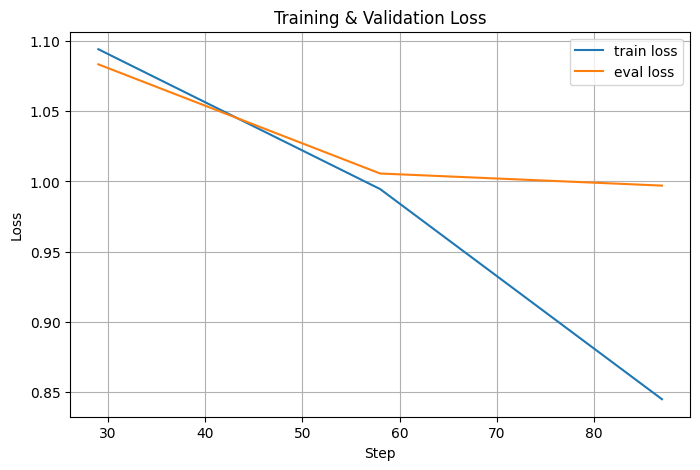

In [119]:
import matplotlib.pyplot as plt
# Convert log history to a DataFrame
logs = pd.DataFrame(trainer.state.log_history)

# Training loss (logged during training steps)
train_loss = logs[logs["loss"].notna()][["step", "loss"]]

# Eval loss (logged during evaluation)
eval_loss = logs[logs["eval_loss"].notna()][["step", "eval_loss"]]

plt.figure(figsize=(8, 5))

plt.plot(train_loss["step"], train_loss["loss"], label="train loss")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="eval loss")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()